In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt


In [2]:
with open('lettres1.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

In [3]:
# affichage d'une lettre
def tracerLettre(let):
    a= -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    plt.savefig("exlettre.png")
    #plt.show()
    return

In [4]:
#teste
tracerLettre(X[20])

# Apprentissage d'un modèle CM (max de vraisemblance)

# 1. Discrétisation

In [5]:
def discretise(X,d):
    
    l = np.ndarray(len(X), dtype=np.object)
    intervalle = 360./d
    for k,x in enumerate(X): 
        l[k]=np.floor(x/intervalle)
        
    return l # return l, ne marche pas 

In [6]:
#teste
xd= discretise(X,3)
print(xd[0])
type(xd)

[ 0.  2.  2.  2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  0.  0.  0.  0.  0.]


numpy.ndarray

In [7]:
#teste
xd= discretise(X,3)
print(xd[0])

[ 0.  2.  2.  2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  0.  0.  0.  0.  0.]


# 2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [8]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y==i)
        index.append(ind)
    return index

In [9]:
#teste
index=groupByLabel(Y) #Chaque ligne regroupe les indices de signaux correspondant à une classe 

# 3. Apprendre les modèles CM

In [10]:
def learnMarkovModel(xc, d):
    """    X : base de signaux discretises correspondant a la classe C
            d : nombre d'etats
            retourne un tuple contenant Pi et A"""
        
    #initialisation:
    A = np.zeros((d,d))
    pi = np.zeros(d)
    
    # Pi0 correspond au nombre d'occurence de chaque etat dans le premier element de chaque sequence 
    for i in range(len(xc)):
        pi[int(xc[i][0])] =   pi[int(xc[i][0])] +1 
      
    # occurence de chaque transaction, il se peut qu'on est des transactions impossible donc = 0
    for i in range(len(xc)):
        for j in range(1,len(xc[i])):
            A[int(xc[i][j-1])][int(xc[i][j])] =     A[int(xc[i][j-1])][int(xc[i][j])]  + 1

    
    # normalisation
    #pour normaliser la matrice de transition on divise chaque ligne i par la somme des elements dans la ligne i idem pour Pi0
    A = A/np.maximum(A.sum(1).reshape(d,1),1) 
    pi = pi/(pi.sum())
    return A,pi   

In [11]:
learnMarkovModel( xd[index[0]]  , 3 )

(array([[ 0.84444444,  0.06666667,  0.08888889],
        [ 0.        ,  0.83333333,  0.16666667],
        [ 0.11382114,  0.06504065,  0.82113821]]),
 array([ 0.36363636,  0.        ,  0.63636364]))

In [12]:
def learnMarkovModel_bis(xc, d):
    """    X : base de signaux discretises correspondant a la classe C
            d : nombre d'etats
            retourne un tuple contenant Pi et A"""
        
    #initialisation avec des 1 pour palier au probleme des 0
    A = np.ones((d,d))
    pi = np.ones(d)
    
    for i in range(len(xc)):
        pi[int(xc[i][0])] =   pi[int(xc[i][0])] +1 
      
    for i in range(len(xc)):
        for j in range(1,len(xc[i])):
            A[int(xc[i][j-1])][int(xc[i][j])] =     A[int(xc[i][j-1])][int(xc[i][j])]  + 1
            
    

    # normalisation
    A = A/np.maximum(A.sum(1).reshape(d,1),1) 
    pi = pi/(pi.sum())
    return A,pi   

In [13]:
learnMarkovModel_bis( xd[index[0]]  , 3 )

(array([[ 0.8125    ,  0.08333333,  0.10416667],
        [ 0.01449275,  0.8115942 ,  0.17391304],
        [ 0.11904762,  0.07142857,  0.80952381]]),
 array([ 0.35714286,  0.07142857,  0.57142857]))

# 4. Constuire les models 

In [14]:
def buildModel( X, Y, d ):
    """
        Construit un modele pour l'apprentissage des CM
        X : donnees sur les lettres
        Y : etiquettes associees
        d : nombre d'etats
    """
    Xd = discretise(X,d)  # application de la discrétisation
    index = groupByLabel(Y)  # groupement des signaux par classe
    models = []
    for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
        models.append(learnMarkovModel(Xd[index[cl]], d))
    
    return Xd, models

In [15]:
d=3
Xd, models = buildModel(X, Y, d)
#models

In [16]:
def buildModel_bis( X, Y, d ):
    """
        Construit un modele pour l'apprentissage des CM
        X : donnees sur les lettres
        Y : etiquettes associees
        d : nombre d'etats
    """
    Xd = discretise(X,d)  # application de la discrétisation
    index = groupByLabel(Y)  # groupement des signaux par classe
    models = []
    for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
        models.append(learnMarkovModel_bis(Xd[index[cl]], d))
    
    return Xd, models

In [17]:
d=3
Xd, models = buildModel_bis(X, Y, d)
models

[(array([[ 0.8125    ,  0.08333333,  0.10416667],
         [ 0.01449275,  0.8115942 ,  0.17391304],
         [ 0.11904762,  0.07142857,  0.80952381]]),
  array([ 0.35714286,  0.07142857,  0.57142857])),
 (array([[ 0.79032258,  0.01612903,  0.19354839],
         [ 0.02439024,  0.95121951,  0.02439024],
         [ 0.08391608,  0.08391608,  0.83216783]]),
  array([ 0.07142857,  0.07142857,  0.85714286])),
 (array([[ 0.91666667,  0.06666667,  0.01666667],
         [ 0.01785714,  0.73214286,  0.25      ],
         [ 0.14117647,  0.03529412,  0.82352941]]),
  array([ 0.28571429,  0.64285714,  0.07142857])),
 (array([[ 0.73529412,  0.23529412,  0.02941176],
         [ 0.01886792,  0.75471698,  0.22641509],
         [ 0.15833333,  0.04166667,  0.8       ]]),
  array([ 0.07142857,  0.07142857,  0.85714286])),
 (array([[ 0.87962963,  0.11111111,  0.00925926],
         [ 0.015625  ,  0.796875  ,  0.1875    ],
         [ 0.13541667,  0.01041667,  0.85416667]]),
  array([ 0.78571429,  0.07142857,  

# Test (affectation dans les classes sur critère MV)

### 1. (log)Probabilité d'une séquence dans un modèle

In [18]:
def probaSequence(s,Pi,A):
    #Pi la proba intiale
    #A la matrice de transission
    #s c'est une sequence quelconque 
    # on utilise la formule P(s1s2s3)= P(s1)*P(s2/s1)*P(s3/s2) 
    #                                = Pi(s1)*A[s1,s2]*A[s2,s3]
    
    x=0
    
    x = np.log(Pi[int(s[0])])
    for i in range(1,len(s)):
        x += np.log(A[int(s[i-1])][int(s[i])])
        
    return x    

In [19]:
# 2.1. Log-probabilite d'une sequence dans un modele
d=3
xd, models = buildModel(X, Y, d)

test = np.zeros( len(models) )

for i, ( A, Pi) in enumerate( models ):
    test[i] = probaSequence(xd[0], Pi, A)
print("log-probabilite du premier signal avec d = 3 etats :")
print(test)

log-probabilite du premier signal avec d = 3 etats :
[-13.491086           -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
 -12.48285678]


C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


# 2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

In [20]:

def classification( Xd, Y, models ):
    #models A Pi
    #sequence  s,Pi,A
    proba = np.array([[probaSequence(Xd[i], models[cl][1], models[cl][0]) for i in range(len(Xd))]for cl in range(len(np.unique(Y)))])
    # Calcul d'une version numerique des Y
    Ynum = np.zeros(Y.shape)
    for num,char in enumerate(np.unique(Y)):
        Ynum[Y==char] = num
    
    # Calcul de la classe la plus probable
    pred = proba.argmax(0) # max colonne par colonne

    # Calcul d'un pourcentage de bonne classification
    perf = np.where(pred != Ynum, 0.,1.).mean()
    
    return perf


In [21]:
#INDICE DE PERFORMANCE : 91% de bonne classification avec 20 états, 69% avec 3 états

In [22]:
Xd3, models3 = buildModel(X, Y, 3)
perf3 = classification(Xd3, Y, models3)
print("Performance avec 3 etats : " + str(perf3))

C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Performance avec 3 etats : 0.690298507463


In [23]:
Xd20, models20 = buildModel(X, Y, 20)
perf20 = classification(Xd20, Y, models20)
print("Performance avec 20 etats : " + str(perf20))
print()

C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Performance avec 20 etats : 0.914179104478



In [24]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y==i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc*n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest


C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


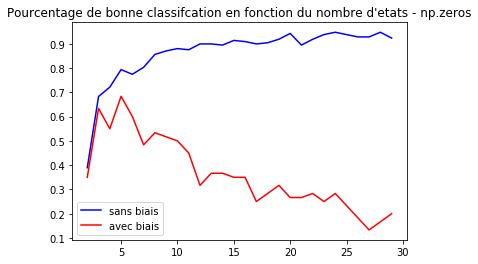

In [27]:
# Biais d'evaluation, notion de sur-apprentissage
itrain,itest = separeTrainTest(Y,0.8)

# re-fusionner tous les indices d'apprentissage et de test
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

etats = range( 2,30 )   # nombre d'etats pour lesquels on va evaluer les modeles
train = []  # liste pour l'apprentissage sans biais
test = []   # liste pour l'apprentissage avec biais

# pour chaque methode d'apprentissage, on calcule ses performances 
# selon le nombre d'etats (discretisation)
for di in etats:
    Xd_train, models = buildModel(X[ia], Y[ia], di) # construire un modele pour l'evaluer sans biais
    Xd_test = discretise(X[it], di)
    train.append(classification(Xd_train, Y[ia], models))
    test.append(classification(Xd_test, Y[it], models))
    
# Afficher les courbes de performances
plt.plot(etats, train, 'b-', label='sans biais')
plt.plot(etats, test, 'r-', label='avec biais')
plt.legend(loc='lower left')
plt.title("Pourcentage de bonne classifcation en fonction du nombre d'etats - np.zeros")
plt.show()



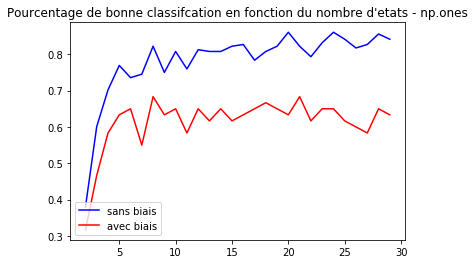

In [26]:
# performances avec initialisation avec np.ones
train_bis = []
test_bis = []
for di_bis in etats:
    Xd_train_bis, models_bis = buildModel_bis(X[ia], Y[ia], di_bis) # construire un modele pour l'evaluer sans biais
    Xd_test_bis = discretise(X[it], di_bis)
    train_bis.append(classification(Xd_train_bis, Y[ia], models_bis))
    test_bis.append(classification(Xd_test_bis, Y[it], models_bis))
plt.plot(etats, train_bis, 'b-', label='sans biais')
plt.plot(etats, test_bis, 'r-', label='avec biais')
plt.legend(loc='lower left')
plt.title("Pourcentage de bonne classifcation en fonction du nombre d'etats - np.ones")
plt.show()